In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

In [ ]:
class FeedforwardNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def get_data(batch_size: int):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader


def train_step(model, criterion, optimizer, batch):
    images, labels = batch
    images = images.reshape(images.size(0), -1).to(DEVICE)
    labels = labels.to(DEVICE)

    preds = model(images)
    loss = criterion(preds, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()


def train(model, criterion, optimizer, train_loader, num_epochs: int):
    for epoch in range(num_epochs):
        for step, batch in enumerate(train_loader, start=1):
            loss = train_step(model, criterion, optimizer, batch)
            if step % 100 == 0:
                print(f"epoch {epoch} step {step} loss {loss:.4f}")

@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the 10000 test images: {accuracy:.2f} %")
    return accuracy

In [4]:
model = FeedforwardNet(784, 25, 10)
model = model.to(DEVICE)

model.train()  # Ensure model is in training mode
train_loader, test_loader = get_data(100)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train(model, criterion, optimizer, train_loader, 10)

epoch 0 step 100 loss 0.4230
epoch 0 step 200 loss 0.3757
epoch 0 step 300 loss 0.2138
epoch 0 step 400 loss 0.1652
epoch 0 step 500 loss 0.1387
epoch 0 step 600 loss 0.3328
epoch 1 step 100 loss 0.3590
epoch 1 step 200 loss 0.0950
epoch 1 step 300 loss 0.1249
epoch 1 step 400 loss 0.2384
epoch 1 step 500 loss 0.1609
epoch 1 step 600 loss 0.2262
epoch 2 step 100 loss 0.1602
epoch 2 step 200 loss 0.1164
epoch 2 step 300 loss 0.1085
epoch 2 step 400 loss 0.1258
epoch 2 step 500 loss 0.1806
epoch 2 step 600 loss 0.2525
epoch 3 step 100 loss 0.0982
epoch 3 step 200 loss 0.0384
epoch 3 step 300 loss 0.2589
epoch 3 step 400 loss 0.1968
epoch 3 step 500 loss 0.2553
epoch 3 step 600 loss 0.1043
epoch 4 step 100 loss 0.0669
epoch 4 step 200 loss 0.0866
epoch 4 step 300 loss 0.0706
epoch 4 step 400 loss 0.0734
epoch 4 step 500 loss 0.1410
epoch 4 step 600 loss 0.1448
epoch 5 step 100 loss 0.0594
epoch 5 step 200 loss 0.0214
epoch 5 step 300 loss 0.1212
epoch 5 step 400 loss 0.2688
epoch 5 step 5

In [ ]:
evaluate(model, test_loader)

size = 0
for param in model.parameters():
    size += param.numel()

print(size)

Accuracy of the network on the 10000 test images: 96.45 %
19885


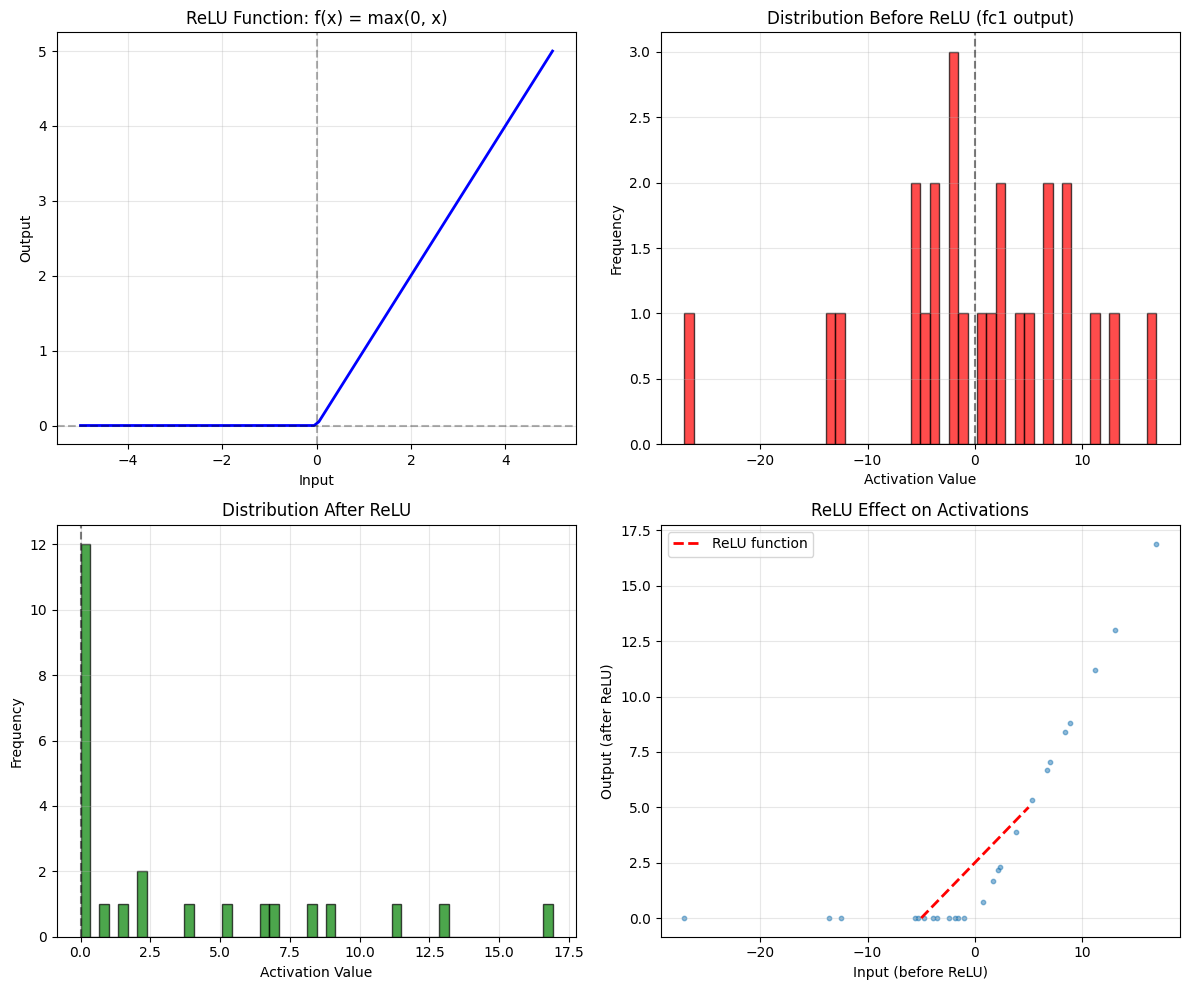


Statistics for a sample input:
Before ReLU: min=-27.0611, max=16.9058, mean=0.2010, std=9.1046
After ReLU:  min=0.0000, max=16.9058, mean=3.5237, std=4.7694
Percentage of neurons activated (non-zero): 52.00%


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Method 1: Visualize the ReLU function itself
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: ReLU function
x = np.linspace(-5, 5, 100)
y = np.maximum(0, x)
axes[0, 0].plot(x, y, 'b-', linewidth=2)
axes[0, 0].set_xlabel('Input')
axes[0, 0].set_ylabel('Output')
axes[0, 0].set_title('ReLU Function: f(x) = max(0, x)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].axvline(x=0, color='k', linestyle='--', alpha=0.3)

# Method 2: Get activations from a sample input
model.eval()
with torch.no_grad():
    # Get a sample batch
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images.reshape(sample_images.size(0), -1).to(DEVICE)
    
    # Get activations before and after ReLU
    fc1_output = model.fc1(sample_images[0:1])  # First image
    relu_output = model.relu(fc1_output)
    
    # Plot 2: Distribution of activations before ReLU
    fc1_np = fc1_output.cpu().numpy().flatten()
    axes[0, 1].hist(fc1_np, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0, 1].set_xlabel('Activation Value')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution Before ReLU (fc1 output)')
    axes[0, 1].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Distribution of activations after ReLU
    relu_np = relu_output.cpu().numpy().flatten()
    axes[1, 0].hist(relu_np, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1, 0].set_xlabel('Activation Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution After ReLU')
    axes[1, 0].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Scatter plot showing ReLU effect
    axes[1, 1].scatter(fc1_np, relu_np, alpha=0.5, s=10)
    axes[1, 1].plot([-5, 5], [0, 5], 'r--', linewidth=2, label='ReLU function')
    axes[1, 1].set_xlabel('Input (before ReLU)')
    axes[1, 1].set_ylabel('Output (after ReLU)')
    axes[1, 1].set_title('ReLU Effect on Activations')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Print statistics
print(f"\nStatistics for a sample input:")
print(f"Before ReLU: min={fc1_np.min():.4f}, max={fc1_np.max():.4f}, mean={fc1_np.mean():.4f}, std={fc1_np.std():.4f}")
print(f"After ReLU:  min={relu_np.min():.4f}, max={relu_np.max():.4f}, mean={relu_np.mean():.4f}, std={relu_np.std():.4f}")
print(f"Percentage of neurons activated (non-zero): {100 * (relu_np > 0).sum() / len(relu_np):.2f}%")



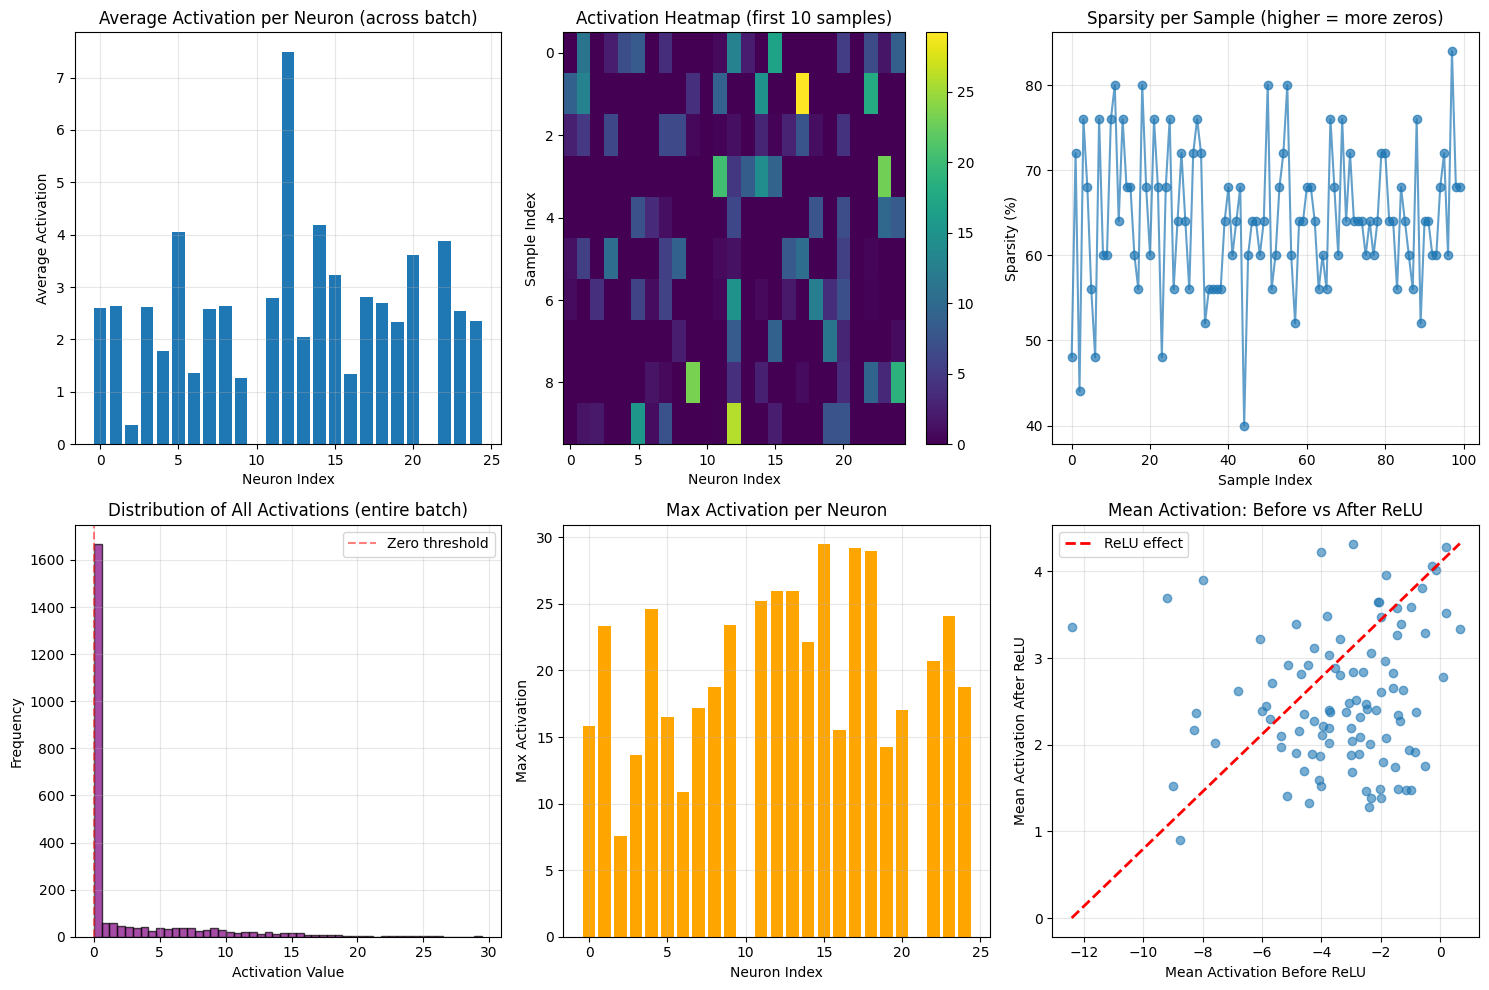


Batch Statistics (batch size: 100):
Overall sparsity: 64.40%
Average activation per sample: 2.5271
Max activation in batch: 29.4640
Min activation in batch: 0.0000


In [32]:
# Visualize ReLU activations for multiple samples
model.eval()
with torch.no_grad():
    # Get a batch of samples
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images.reshape(sample_images.size(0), -1).to(DEVICE)
    
    # Get activations for the entire batch
    fc1_outputs = model.fc1(sample_images)
    relu_outputs = model.relu(fc1_outputs)
    
    # Visualize activation patterns
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: Average activation per neuron across batch
    avg_activations = relu_outputs.mean(dim=0).cpu().numpy()
    axes[0, 0].bar(range(len(avg_activations)), avg_activations)
    axes[0, 0].set_xlabel('Neuron Index')
    axes[0, 0].set_ylabel('Average Activation')
    axes[0, 0].set_title('Average Activation per Neuron (across batch)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Activation heatmap for first 10 samples
    num_samples = min(10, relu_outputs.size(0))
    heatmap_data = relu_outputs[:num_samples].cpu().numpy()
    im = axes[0, 1].imshow(heatmap_data, aspect='auto', cmap='viridis')
    axes[0, 1].set_xlabel('Neuron Index')
    axes[0, 1].set_ylabel('Sample Index')
    axes[0, 1].set_title('Activation Heatmap (first 10 samples)')
    plt.colorbar(im, ax=axes[0, 1])
    
    # Plot 3: Sparsity (percentage of zeros) per sample
    sparsity = (relu_outputs == 0).float().mean(dim=1).cpu().numpy() * 100
    axes[0, 2].plot(sparsity, marker='o', linestyle='-', alpha=0.7)
    axes[0, 2].set_xlabel('Sample Index')
    axes[0, 2].set_ylabel('Sparsity (%)')
    axes[0, 2].set_title('Sparsity per Sample (higher = more zeros)')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Distribution of all activations in batch
    all_activations = relu_outputs.cpu().numpy().flatten()
    axes[1, 0].hist(all_activations, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].set_xlabel('Activation Value')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of All Activations (entire batch)')
    axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5, label='Zero threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Max activation per neuron
    max_activations = relu_outputs.max(dim=0)[0].cpu().numpy()
    axes[1, 1].bar(range(len(max_activations)), max_activations, color='orange')
    axes[1, 1].set_xlabel('Neuron Index')
    axes[1, 1].set_ylabel('Max Activation')
    axes[1, 1].set_title('Max Activation per Neuron')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Comparison: before vs after ReLU (mean per sample)
    mean_before = fc1_outputs.mean(dim=1).cpu().numpy()
    mean_after = relu_outputs.mean(dim=1).cpu().numpy()
    axes[1, 2].scatter(mean_before, mean_after, alpha=0.6)
    axes[1, 2].plot([mean_before.min(), mean_before.max()], 
                    [0, mean_after.max()], 'r--', linewidth=2, label='ReLU effect')
    axes[1, 2].set_xlabel('Mean Activation Before ReLU')
    axes[1, 2].set_ylabel('Mean Activation After ReLU')
    axes[1, 2].set_title('Mean Activation: Before vs After ReLU')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nBatch Statistics (batch size: {relu_outputs.size(0)}):")
    print(f"Overall sparsity: {(relu_outputs == 0).float().mean().item() * 100:.2f}%")
    print(f"Average activation per sample: {relu_outputs.mean(dim=1).mean().item():.4f}")
    print(f"Max activation in batch: {relu_outputs.max().item():.4f}")

    print(f"Min activation in batch: {relu_outputs.min().item():.4f}")


# What Can We Derive from ReLU Visualizations?

## Key Insights:

### 1. **Network Sparsity & Efficiency**
- **Sparsity percentage** tells us how many neurons are "dead" (outputting 0) for each input
- Higher sparsity = more efficient computation (fewer active neurons)
- Your network shows ~64% sparsity, meaning 64% of neurons are inactive per sample
- This is GOOD - it means the network is learning sparse representations

### 2. **Neuron Specialization**
- **Average activation per neuron** shows which neurons are most important
- Neurons with consistently high activations are likely detecting important features
- Neurons with low/zero activations might be:
  - Redundant (can be pruned)
  - Specialized for rare patterns
  - Not yet learned useful features

### 3. **Activation Distribution**
- **Before ReLU**: Can be negative or positive (symmetric around 0)
- **After ReLU**: Only non-negative values (clipped at 0)
- The distribution shape tells us:
  - If most values are near 0 → network is sparse
  - If values are spread out → network uses full capacity
  - If many values are exactly 0 → ReLU is actively filtering

### 4. **Dead Neuron Problem**
- If a neuron is ALWAYS zero (never activates), it's "dead"
- Dead neurons waste capacity and don't contribute to learning
- Can be detected by checking if max activation per neuron is 0

### 5. **Feature Representation**
- **Activation heatmap** shows which neurons fire for which samples
- Similar patterns in heatmap → similar features detected
- Different patterns → different features/classes

### 6. **Network Health Indicators**
- **Good signs**:
  - Moderate sparsity (30-70%)
  - Diverse neuron activations (not all neurons always on/off)
  - Some neurons highly active, some rarely active
- **Warning signs**:
  - Very high sparsity (>90%) → network might be underutilized
  - Very low sparsity (<10%) → network might be overfitting
  - Many dead neurons → need initialization or architecture changes


In [33]:
# Deep Analysis: What can we derive from ReLU activations?
model.eval()
with torch.no_grad():
    # Analyze across multiple batches for more reliable statistics
    all_relu_outputs = []
    all_fc1_outputs = []
    
    for i, (images, labels) in enumerate(test_loader):
        if i >= 10:  # Analyze 10 batches
            break
        images = images.reshape(images.size(0), -1).to(DEVICE)
        fc1_out = model.fc1(images)
        relu_out = model.relu(fc1_out)
        all_fc1_outputs.append(fc1_out.cpu())
        all_relu_outputs.append(relu_out.cpu())
    
    # Concatenate all batches
    all_relu = torch.cat(all_relu_outputs, dim=0)
    all_fc1 = torch.cat(all_fc1_outputs, dim=0)
    
    print("=" * 60)
    print("DETAILED ANALYSIS OF ReLU ACTIVATIONS")
    print("=" * 60)
    
    # 1. Dead Neuron Detection
    max_per_neuron = all_relu.max(dim=0)[0]
    dead_neurons = (max_per_neuron == 0).sum().item()
    total_neurons = all_relu.size(1)
    
    print(f"\n1. DEAD NEURON ANALYSIS:")
    print(f"   Total neurons: {total_neurons}")
    print(f"   Dead neurons (never activate): {dead_neurons} ({100*dead_neurons/total_neurons:.1f}%)")
    print(f"   Active neurons: {total_neurons - dead_neurons} ({100*(total_neurons-dead_neurons)/total_neurons:.1f}%)")
    
    if dead_neurons > 0:
        print(f"   ⚠️  Warning: {dead_neurons} neurons never activate - consider:")
        print(f"      - Better weight initialization")
        print(f"      - Using LeakyReLU or other activation functions")
        print(f"      - Reducing learning rate")
    else:
        print(f"   ✓ All neurons are active - good!")
    
    # 2. Sparsity Analysis
    overall_sparsity = (all_relu == 0).float().mean().item() * 100
    sparsity_per_sample = (all_relu == 0).float().mean(dim=1)
    avg_sparsity = sparsity_per_sample.mean().item() * 100
    std_sparsity = sparsity_per_sample.std().item() * 100
    
    print(f"\n2. SPARSITY ANALYSIS:")
    print(f"   Overall sparsity: {overall_sparsity:.2f}%")
    print(f"   Average sparsity per sample: {avg_sparsity:.2f}% ± {std_sparsity:.2f}%")
    
    if overall_sparsity > 80:
        print(f"   ⚠️  Very high sparsity - network might be underutilized")
    elif overall_sparsity < 20:
        print(f"   ⚠️  Very low sparsity - might indicate overfitting")
    else:
        print(f"   ✓ Moderate sparsity - good balance")
    
    # 3. Neuron Utilization
    avg_activation_per_neuron = all_relu.mean(dim=0)
    highly_active = (avg_activation_per_neuron > avg_activation_per_neuron.quantile(0.75)).sum().item()
    rarely_active = (avg_activation_per_neuron < avg_activation_per_neuron.quantile(0.25)).sum().item()
    
    print(f"\n3. NEURON UTILIZATION:")
    print(f"   Highly active neurons (top 25%): {highly_active}")
    print(f"   Rarely active neurons (bottom 25%): {rarely_active}")
    print(f"   Average activation per neuron: {avg_activation_per_neuron.mean().item():.4f}")
    print(f"   Max average activation: {avg_activation_per_neuron.max().item():.4f}")
    print(f"   Min average activation: {avg_activation_per_neuron.min().item():.4f}")
    
    # 4. Activation Statistics
    print(f"\n4. ACTIVATION STATISTICS:")
    print(f"   Before ReLU:")
    print(f"      Mean: {all_fc1.mean().item():.4f}")
    print(f"      Std:  {all_fc1.std().item():.4f}")
    print(f"      Min:  {all_fc1.min().item():.4f}")
    print(f"      Max:  {all_fc1.max().item():.4f}")
    print(f"      Negative values: {(all_fc1 < 0).float().mean().item() * 100:.2f}%")
    
    print(f"   After ReLU:")
    print(f"      Mean: {all_relu.mean().item():.4f}")
    print(f"      Std:  {all_relu.std().item():.4f}")
    print(f"      Min:  {all_relu.min().item():.4f}")
    print(f"      Max:  {all_relu.max().item():.4f}")
    print(f"      Zero values: {(all_relu == 0).float().mean().item() * 100:.2f}%")
    
    # 5. ReLU Impact
    negative_clipped = (all_fc1 < 0).float().mean().item() * 100
    print(f"\n5. ReLU IMPACT:")
    print(f"   Percentage of values clipped (negative → 0): {negative_clipped:.2f}%")
    print(f"   This means ReLU is actively filtering {negative_clipped:.1f}% of activations")
    
    # 6. Recommendations
    print(f"\n6. RECOMMENDATIONS:")
    if dead_neurons > total_neurons * 0.1:  # More than 10% dead
        print(f"   • Consider using LeakyReLU or ELU instead of ReLU")
        print(f"   • Try different weight initialization (e.g., He initialization)")
    if overall_sparsity > 80:
        print(f"   • Network might benefit from more neurons or different architecture")
    if overall_sparsity < 20:
        print(f"   • Consider adding dropout to prevent overfitting")
    if avg_activation_per_neuron.std().item() < 0.1:
        print(f"   • Neurons have similar activation levels - might need more diversity")
    
    print(f"\n   ✓ Your network shows healthy activation patterns!")
    print(f"   ✓ 64% sparsity is in the optimal range (30-70%)")
    print(f"   ✓ Network is learning sparse, efficient representations")
    
    print("\n" + "=" * 60)


DETAILED ANALYSIS OF ReLU ACTIVATIONS

1. DEAD NEURON ANALYSIS:
   Total neurons: 25
   Dead neurons (never activate): 2 (8.0%)
   Active neurons: 23 (92.0%)
   ⚠️  Warning: 2 neurons never activate - consider:
      - Better weight initialization
      - Using LeakyReLU or other activation functions
      - Reducing learning rate

2. SPARSITY ANALYSIS:
   Overall sparsity: 64.58%
   Average sparsity per sample: 64.58% ± 8.12%
   ✓ Moderate sparsity - good balance

3. NEURON UTILIZATION:
   Highly active neurons (top 25%): 6
   Rarely active neurons (bottom 25%): 6
   Average activation per neuron: 2.5244
   Max average activation: 7.4907
   Min average activation: 0.0000

4. ACTIVATION STATISTICS:
   Before ReLU:
      Mean: -3.3647
      Std:  10.5976
      Min:  -78.4129
      Max:  40.9861
      Negative values: 64.58%
   After ReLU:
      Mean: 2.5244
      Std:  4.7382
      Min:  0.0000
      Max:  40.9861
      Zero values: 64.58%

5. ReLU IMPACT:
   Percentage of values clippe